## Import Packages


In [2]:
#inbuilt packages 
import os
from PIL import Image
from tqdm import tqdm

#datascience packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

#PyTorch related packages
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


In [3]:
os.getcwd()
os.chdir('facial_key_point')


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'facial_key_point'

## Hyper Parameters


In [4]:
batch_size = 16
model_input_size = (224, 224)
n_epoch = 10
learning_rate = 0.001

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Loader


In [5]:
class FaceKeyPointData(Dataset):
    def __init__(self, csv_path='data\\test_frames_keypoints.csv', split='training', device=torch.device('cpu')):
        super(FaceKeyPointData, self).__init__()
        self.csv_path = csv_path
        self.split = split
        self.df = pd.read_csv(self.csv_path)
        self.normalize = transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
        self.device = device 
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img, original_size = self.get_img(index)
        key_points = self.get_keypoints(index = index, original_size = original_size)
        return img, key_points
    
    def get_img(self, index):
        img_path = os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index, 0])
        img = Image.open(img_path).convert('RGB')
        original_size = img.size

    #preprocessing image 
        img = img.resize(model_input_size, Image.Resampling.BILINEAR)
        img = np.asarray(img) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)     #transposing
        img = self.normalize(img).float()
        return img.to(self.device), original_size
    
    def get_keypoints(self, index, original_size):
        kp = self.df.iloc[index, 1:].to_numpy().astype(np.float32)
        kp_x = np.array(kp[0::2]) / original_size[0]
        kp_y = np.array(kp[1::2]) / original_size[1]
        kp = np.concatenate((kp_x, kp_y))
        return torch.tensor(kp).to(self.device)
    
    def load_img(self, index):
        img_path = os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index, 0])
        img = Image.open(img_path).convert('RGB')
        img = img.resize(model_input_size, Image.Resampling.BILINEAR)
        return np.asarray(img) / 255.0
    
training_data = FaceKeyPointData(device=device)
test_data = FaceKeyPointData(csv_path='data\\test_frames_keypoints.csv', split='test', device=device)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\test_frames_keypoints.csv'

In [67]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [68]:
batch_img, batch_key_points = next(iter(train_dataloader))
batch_img.shape, batch_key_points.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 136]))

## Data Visualization

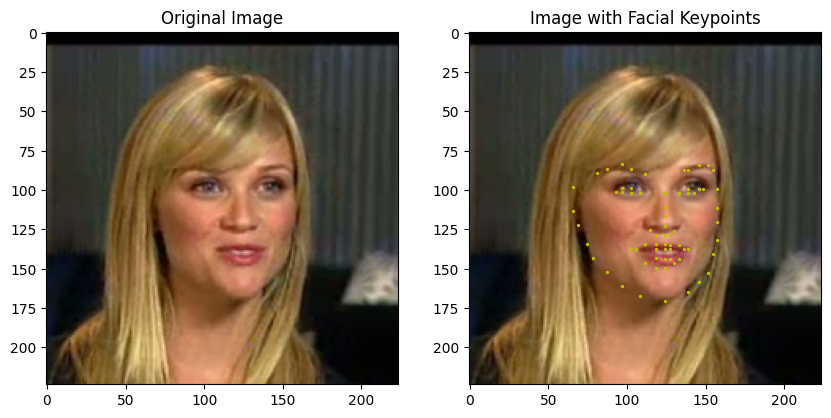

In [69]:
img_index = 60
img = training_data.load_img(img_index)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img_tensor, kp_s = training_data[img_index]
kp_x = kp_s[:68].cpu().numpy() * model_input_size[0]
kp_y = kp_s[68:].cpu().numpy() * model_input_size[1]
plt.scatter(kp_x, kp_y, c='y', s=2)


## Model Building


In [70]:
def get_model(device):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    for layers in vgg16.parameters():
        layers.requires_grad = False

    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, 3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )

    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()    
    )   
    return model.to(device=device)
model = get_model(device=device)


In [71]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [72]:
def train_batch(imgs, kps, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    #forward pass
    kps_pred = model(imgs)
    loss = criterion(kps_pred, kps)

    #backward pass
    loss.backward()
    optimizer.step()

    return loss

In [73]:
@torch.no_grad()
def test_batch(imgs, kps, model, criterion):
    model.eval()

    #forward pass
    kps_pred = model(imgs)
    loss = criterion(kps_pred, kps)

    return loss

## Training Pipeline


In [75]:
train_loss = []
test_loss = []

for epoch in range (1, n_epoch+1):
    epoch_train_loss, epoch_test_loss = 0, 0

    #train
    for images, kps in tqdm (train_dataloader, desc= f'Training {epoch}/{n_epoch}'):
        images = images.float()  # Convert images to float
        loss = train_batch(images, kps, model, criterion, optimizer)
        epoch_train_loss += loss.item()
    epoch_train_loss /= len(train_dataloader)
    train_loss.append(epoch_train_loss)

    
    #validation
    for images, kps in tqdm (test_dataloader, desc= f'Testing {epoch}/{n_epoch}'):
        images = images.float()  # Convert images to float
        loss = test_batch(images, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= len(test_dataloader)
    test_loss.append(epoch_test_loss)

    print(f'Epoch {epoch}/{n_epoch} : Train Loss: {epoch_train_loss}, Test Loss: {epoch_test_loss}')



Training 1/10:  80%|███████▉  | 39/49 [13:45<03:47, 22.72s/it]

## Train and Test Curve

In [ ]:
epochs = np.arange(1, n_epoch+1)

plt.figure()
plt.plot(epochs, train_loss, 'b' label='Train Loss')
plt.plot(epochs, test_loss, 'r' label='Test Loss')
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Result Visualization

In [ ]:
img_index = 11
img = test_data.load_img(img_index)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img = test_data[img_index]
kp_s = kp_s.to('cpu')
plt.scatter(kp_s[:68] * model_input_size[0], kp_s[68:] * model_input_size[1], c='y', s=2)

In [ ]:
test_data[img_index]
img.shape

In [ ]:
model(img[None].flatten().detach().cpu())